# 네이버 영화 리뷰 감정 분류

* 한글 텍스트 분류를 다양하게 진행함으로서, NLP의 한 분야인 Text Classifiction에 대한 이해를 하고자 합니다.
* 이번 프로젝트에서 사용할 기술은 다음과 같습니다.

* **Preprocessing Method**
  - **KoNLPy Okt** : 형태소 추출
  - **regex** : 정규 표현식, 특수문자 처리
  - **stop word** : 불용어 처리
<br>
<br>
* **Word Representation**
  - **TD-IDF**
  - **Word2Vec**
  - **Tokenizer + Padding**
<br>
<br>
* **Classifiction Model**
  - **ML Model** : Logisic Regression, Random Forest, Decision Tree, XGBoost
  - **DL Model** : RNN, CNN(Convolution Neural Network for Sentence Classifiction - Yoon Kim(2014))
  - **stacking** : 과적합 방지를 위한 CV 기반의 stacking 모델
<br>
<br>
* **Search Parameter**
  - **Bayesian optimization** : 베이지안 네트워크 최적화를 통한 최적 hyperparameter 탐색.

* **train/test split**
  - **KFold Cross Validation** : 과적합 방지를 위한 KFold train/test Split 사용. 

* **Metric**
  - **Accuracy** : 평가 지표로는 정확도만 사용하였습니다.

<br>
<br>

* **Model Accuracy Result**

|Word Representation|Model|Eval Accuracy(%)|Predict Accuracy(%)|
|--|--|--|--|
|**Word2Vec**|**LogisticRegression**|$0.8002$|$0.8029$|
|**Word2Vec**|**RandomForestClassifier**|$0.8017$|$0.8064$|
|**Word2Vec**|**XGBClassifier**|$0.8062$|$0.8035$|
|**Word2Vec**|**DecisionTreeClassifier**|$0.7164$|$0.7281$|
|**Word2Vec**|**CNN**|||
|**Word2Vec**|**RNN**|||
|**TF-IDF**|**LogisticRegression**|$0.8501$|$0.8620$|
|**TF-IDF**|**RandomForestClassifier**|$0.8106$|$0.7949$|
|**TF-IDF**|**XGBClassifier**|$0.7831$|$0.7282$|
|**TF-IDF**|**DecisionTreeClassifier**|$0.7308$|$0.6700$|
|**TD-IDF**|**DNN**|||
|**Tokenizer + Padding**|**LogisticRegression**|$0.5154$|$-$|
|**Tokenizer + Padding**|**RandomForestClassifier**|$0.6353$|$-$|
|**Tokenizer + Padding**|**XGBClassifier**|$0.6961$|$-$|
|**Tokenizer + Padding**|**DecisionTreeClassifier**|$0.6054$|$-$|
|**TD-IDF**|**DNN**|||
|**Tokenizer + Padding**|**CNN**|||




# 1. Library load

In [79]:
import os
import json
import logging
from joblib import dump, load
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# EDA : visualization Library
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# Preprocessing Library
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

# stop words
import utils 

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# WordToVector
from gensim.models import word2vec


# Train/Test Split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Classification Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# hyper paramter search
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

# Metric
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import InputLayer, Embedding, Conv1D, Dropout, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.activations import relu, sigmoid

## 1.1 folder & path setting

In [80]:
# 경로 설정
ORIGINAL_PATH = os.path.join(os.getcwd(), 'data')
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
MODEL_PATH = os.path.join(os.getcwd(), 'model')
PREDCIT_PATH = os.path.join(os.getcwd(),'predict')
ETC_PATH = os.path.join(os.getcwd(),'etc')
CONFIGS = {'path' : {}, 'paramter' : {}}

In [81]:
# 경로 확인 및 생성
def check_dir(path_lst) :
    for path in path_lst :
        if os.path.exists(path) :
            print(f'{path} -- Folder Already Exist')
        else :
            os.makedirs(path)
            print(f'{path} -- Make Folder')
check_path_lst = [ORIGINAL_PATH, PREPROCESSED_PATH, MODEL_PATH, PREDCIT_PATH, ETC_PATH]
check_dir(check_path_lst)

c:\Users\user\Desktop\github\naver_movie_review_classification\data -- Folder Already Exist
c:\Users\user\Desktop\github\naver_movie_review_classification\preprocessed -- Folder Already Exist
c:\Users\user\Desktop\github\naver_movie_review_classification\model -- Folder Already Exist
c:\Users\user\Desktop\github\naver_movie_review_classification\predict -- Folder Already Exist
c:\Users\user\Desktop\github\naver_movie_review_classification\etc -- Folder Already Exist


In [82]:
CONFIGS['path']['path_original'] = ORIGINAL_PATH
CONFIGS['path']['path_preprocessed'] = PREPROCESSED_PATH
CONFIGS['path']['path_model_paramter'] = MODEL_PATH
CONFIGS['path']['path_predict'] = PREDCIT_PATH
CONFIGS['path']['path_etc'] = ETC_PATH

In [83]:
CONFIGS

{'path': {'path_original': 'c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\data',
  'path_preprocessed': 'c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\preprocessed',
  'path_model_paramter': 'c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model',
  'path_predict': 'c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\predict',
  'path_etc': 'c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\etc'},
 'paramter': {}}

# 2. EDA

In [84]:
print('파일 크기 확인 : ')
for file in os.listdir(ORIGINAL_PATH) :
    if 'txt' in file :
        print(file.ljust(30) + str(round(os.path.getsize(os.path.join(ORIGINAL_PATH, file))/1000000, 2)) + 'MB')

파일 크기 확인 : 
ratings.txt                   19.52MB
ratings_test.txt              4.89MB
ratings_train.txt             14.63MB


In [85]:
train_data = pd.read_csv(os.path.join(ORIGINAL_PATH, 'ratings_train.txt'), header=0, delimiter='\t', quoting=3)
test_data = pd.read_csv(os.path.join(ORIGINAL_PATH, 'ratings_test.txt'), header=0, delimiter='\t', quoting=3)
print(f'학습 데이터 : {len(train_data)}, 테스트 데이터 : {len(test_data)}')
display(train_data.sample(5))
display(test_data.sample(5))

학습 데이터 : 150000, 테스트 데이터 : 50000


,id,document,label
44226,7807728,어떻게봐요이거?,1
21898,5523512,졸라 잼없음,0
82712,9882730,상당히 잘만든영화...자극도 없고 물흐르듯 흐르는 영화 간만의 지대로 일본영화였음...,1
146494,8469567,1 점도 아까운. 개연성 전혀 없는 사건들.,0
37483,10136764,영상미가 너무 아름답다 이 영화를 본지 시간이 꽤 지났는데도 아직도 선명하게 아름다웠다.,1


,id,document,label
3209,8384111,작가가 대체 법원이란델 가보고 쓴거냐 ㅋㅋ 교도소에서 어떡해 핸드폰으로 녹음을하고 ...,0
30693,9891116,엄청 지루함... 거기 아빠가 노트북 만질때 졸기 시작하다가 2편에 나온 입양된 헌...,0
16414,7141003,굉장히 오래됐지만 재미있게 본 영화,1
26468,8875889,개빡치는 영화입니다 츠천,0
42245,9537029,시나리오 진짜 개나소나쓰냐?? 이딴개 대상작???ㅋ,0


In [8]:
# 리뷰 추출
train_review = [review for review in train_data['document'] if type(review) is str]
test_review = [review for review in test_data['document'] if type(review) is str]

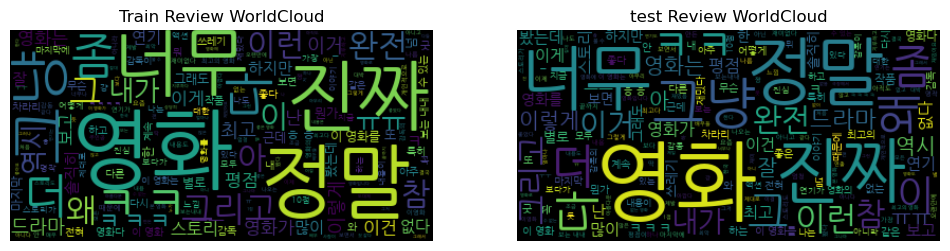

In [10]:
# Train/Test 데이터 World Cloud 시각화
train_wordcloud = WordCloud(font_path=os.path.join(ETC_PATH, 'NanumGothic.ttf')).generate(" ".join(train_review))
test_wordcloud = WordCloud(font_path=os.path.join(ETC_PATH, 'NanumGothic.ttf')).generate(" ".join(test_review))

fig, axes = plt.subplots(ncols=2);
fig.set_size_inches(12, 4);
axes[0].imshow(train_wordcloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title('Train Review WorldCloud')
axes[1].imshow(test_wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title('test Review WorldCloud')
plt.show()

[TRAIN] 긍정 리뷰 개수 : 74827 부정 리뷰 수 : 75173
[TEST] 긍정 리뷰 개수 : 25173 부정 리뷰 수 : 24827


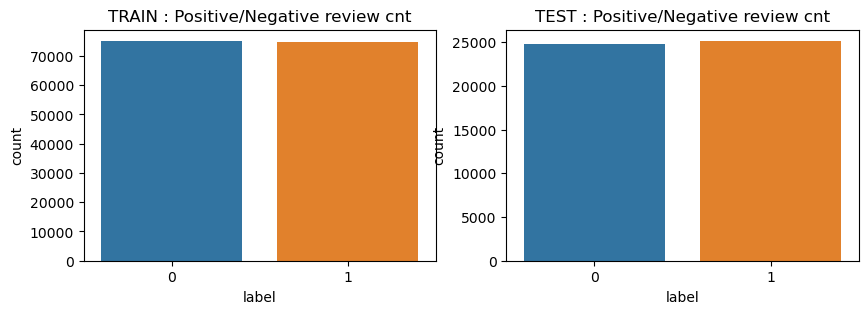

In [11]:
# 긍정/부정 라벨 분포 확안
fig, axes = plt.subplots(ncols=2);
fig.set_size_inches(10, 3);
sns.countplot(train_data['label'], ax = axes[0]);
axes[0].set_title('TRAIN : Positive/Negative review cnt')
sns.countplot(test_data['label'], ax = axes[1]);
axes[1].set_title('TEST : Positive/Negative review cnt')

# 라벨 별 리뷰 개수 확인
print(f"[TRAIN] 긍정 리뷰 개수 : {train_data['label'].value_counts()[1]} 부정 리뷰 수 : {train_data['label'].value_counts()[0]}")
print(f"[TEST] 긍정 리뷰 개수 : {test_data['label'].value_counts()[1]} 부정 리뷰 수 : {test_data['label'].value_counts()[0]}")

Text(0.5, 1.0, 'Number of Words in Test review')

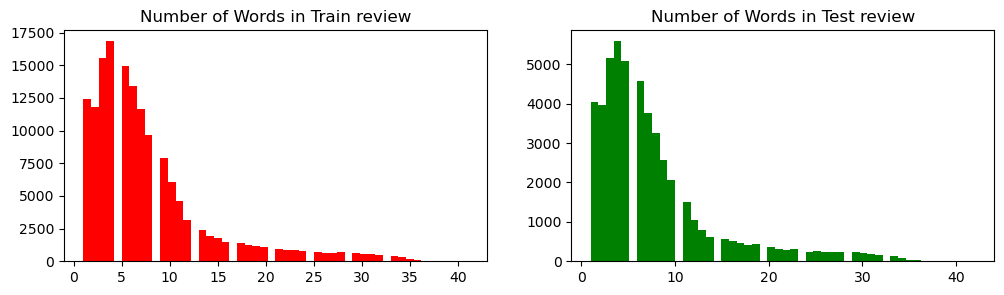

In [12]:
# 리뷰 단어 개수 분포 확안
train_word_cnt = train_data['document'].astype(str).apply(lambda x : len(x.split(' ')))
test_word_cnt = test_data['document'].astype(str).apply(lambda x : len(x.split(' ')))

fig, axes = plt.subplots(ncols=2);
fig.set_size_inches(12, 3);
axes[0].hist(train_word_cnt, bins=50, color='r', label='word');
axes[0].set_title('Number of Words in Train review')

axes[1].hist(test_word_cnt, bins=50, color='g', label='word');
axes[1].set_title('Number of Words in Test review')

In [13]:
# 단어의 분포 확인
print('Train/Test 단어 최대값 : {} / {}'.format(np.max(train_word_cnt), np.max(test_word_cnt)))
print('Train/Test 단어 최소값 : {} / {}'.format(np.min(train_word_cnt), np.min(test_word_cnt),))
print('Train/Test 단어 평균값 : {:.2f} / {:.2f}'.format(np.mean(train_word_cnt), np.mean(test_word_cnt)))
print('Train/Test 단어 표준편차 : {:.3f} / {:.3f}'.format(np.std(train_word_cnt), np.std(test_word_cnt)))
print('Train/Test 단어 중간값 : {} / {}'.format(np.median(train_word_cnt), np.median(test_word_cnt)))
print('Train/Test 단어 제1사분위 : {} / {}'.format(np.percentile(train_word_cnt, 25), np.percentile(test_word_cnt, 25)))
print('Train/Test 단어 제2사분위 : {} / {}'.format(np.percentile(train_word_cnt, 50), np.percentile(test_word_cnt, 50)))
print('Train/Test 단어 제3사분위 : {} / {}'.format(np.percentile(train_word_cnt, 75), np.percentile(test_word_cnt, 75)))

print('Train/Test 단어 80% : {} / {}'.format(np.percentile(train_word_cnt, 80), np.percentile(test_word_cnt, 80)))
print('Train/Test 단어 85% : {} / {}'.format(np.percentile(train_word_cnt, 85), np.percentile(test_word_cnt, 85)))
print('Train/Test 단어 90% : {} / {}'.format(np.percentile(train_word_cnt, 90), np.percentile(test_word_cnt, 90)))
print('Train/Test 단어 95% : {} / {}'.format(np.percentile(train_word_cnt, 95), np.percentile(test_word_cnt, 95)))


# 특수문자 유무 확인
train_qmarks = np.mean(train_data['document'].astype(str).apply(lambda x : '?' in x)) # ?가 존재
train_hat = np.mean(train_data['document'].astype(str).apply(lambda x : '!' in x)) # !가 존재
train_stop = np.mean(train_data['document'].astype(str).apply(lambda x : '.' in x)) # .가 존재

# 특수문자 유무 확인
test_qmarks = np.mean(test_data['document'].astype(str).apply(lambda x : '?' in x)) # ?가 존재
test_hat = np.mean(test_data['document'].astype(str).apply(lambda x : '!' in x)) # !가 존재
test_stop = np.mean(test_data['document'].astype(str).apply(lambda x : '.' in x)) # .가 존재

print("Train/Test include -> ? : {:.2f}% / {:.2f}%".format(train_qmarks*100, test_qmarks*100))
print("Train/Test include -> ! : {:.2f}% / {:.2f}%".format(train_hat*100, test_hat*100))
print("Train/Test include -> . : {:.2f}% / {:.2f}%".format(train_stop*100, test_stop*100))

Train/Test 단어 최대값 : 41 / 42
Train/Test 단어 최소값 : 1 / 1
Train/Test 단어 평균값 : 7.58 / 7.61
Train/Test 단어 표준편차 : 6.514 / 6.534
Train/Test 단어 중간값 : 6.0 / 6.0
Train/Test 단어 제1사분위 : 3.0 / 3.0
Train/Test 단어 제2사분위 : 6.0 / 6.0
Train/Test 단어 제3사분위 : 9.0 / 9.0
Train/Test 단어 80% : 10.0 / 10.0
Train/Test 단어 85% : 12.0 / 12.0
Train/Test 단어 90% : 16.0 / 16.0
Train/Test 단어 95% : 23.0 / 23.0
Train/Test include -> ? : 8.25% / 8.28%
Train/Test include -> ! : 9.38% / 9.31%
Train/Test include -> . : 51.76% / 51.60%


* **EDA**
    - World Cloud를 통해 "그냥", "영화", "진짜", "너무", "더", "이렇게", "ㅋ ㅋ", "정말", "좀", "왜"등과 같이 자주 쓰이는 단어들이 공통적으로 등장.  
    - 수치상으로는 Train/Test 데이터가 균형있게 분리되어 있음.
    - 리뷰당 단어의 수는 16개 이하(90%)로 구성됨.

# 3. Preprocessing

### 3.1 Word Enbedding 표현 전 기본 전처리

In [87]:
# Word Embedding 전 전처리 함수
def preprocessing(review, okt, remove_stopwords = False, stop_words=[]) :
    # 1. 특수문자 처리 : 한글, 공백, 숫자 제외 다 제거
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s1-9]", "", review)
    # 2. 형태소 분리 : Okt 객체
    review_text = okt.morphs(review_text, stem=True)
    # 3. 불용어 처리
    if remove_stopwords :
        clean_review = [token for token in review_text if not token in stop_words]
    return clean_review

stop_words = utils.stop_word    # 불용서 생성
okt = Okt()                     # 형태소 분리 객체 생성

# 훈련데이터 전처리
pp_train_review = []
for review in tqdm(train_data['document']) :
    # (*) 비어있는 데이터에서 에러나지 않게 처리
    if type(review) == str :
        pp_train_review.append(preprocessing(review, okt, True, stop_words))
    else :
        pp_train_review.append([])
    

# 테스트 데이터 전처리
pp_test_review = []
for review in tqdm(test_data['document']) :
    # (*) 비어있는 데이터에서 에러나지 않게 처리
    if type(review) == str :
        pp_test_review.append(preprocessing(review, okt, True, stop_words))
    else :
        pp_test_review.append([])

100%|██████████| 50000/50000 [02:13<00:00, 374.28it/s]


In [15]:
for i in range(3) :
    print(f" TRAIN : {train_data['document'][i]} -> {pp_train_review[i]}")
    print(f" TEST : {test_data['document'][i]} -> {pp_test_review[i]}")

 TRAIN : 아 더빙.. 진짜 짜증나네요 목소리 -> ['더빙', '진짜', '짜증나다', '목소리']
 TEST : 굳 ㅋ -> ['굳다', 'ㅋ']
 TRAIN : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 -> ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍다', '않다']
 TEST : GDNTOPCLASSINTHECLUB -> []
 TRAIN : 너무재밓었다그래서보는것을추천한다 -> ['무재', '밓었', '다그', '래서', '보다', '추천', '한', '다']
 TEST : 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 -> ['뭐', '평점', '은', '나쁘다', '않다', '1', '점', '짜다', '리', '는', '더', '더욱', '아니다']


In [16]:
# 긍정/부정 라벨 분포 확인
pp_train_word_cnt, pp_test_word_cnt = [], []
for review_train, review_test in zip(pp_train_review, pp_test_review) :
    pp_train_word_cnt.append(len(review_train))
    pp_test_word_cnt.append(len(review_test))

print('Train/Test 전처리 단어 제1사분위 : {} / {}'.format(np.percentile(pp_train_word_cnt, 25), np.percentile(pp_test_word_cnt, 25)))
print('Train/Test 전처리 단어 제2사분위 : {} / {}'.format(np.percentile(pp_train_word_cnt, 50), np.percentile(pp_test_word_cnt, 50)))
print('Train/Test 전처리 단어 제3사분위 : {} / {}'.format(np.percentile(pp_train_word_cnt, 75), np.percentile(pp_test_word_cnt, 75)))
print('Train/Test 전처리 단어 80% : {} / {}'.format(np.percentile(pp_train_word_cnt, 80), np.percentile(pp_test_word_cnt, 80)))
print('Train/Test 전처리 단어 85% : {} / {}'.format(np.percentile(pp_train_word_cnt, 85), np.percentile(pp_test_word_cnt, 85)))
print('Train/Test 전처리 단어 90% : {} / {}'.format(np.percentile(pp_train_word_cnt, 90), np.percentile(pp_test_word_cnt, 90)))
print('Train/Test 전처리 단어 95% : {} / {}'.format(np.percentile(pp_train_word_cnt, 95), np.percentile(pp_test_word_cnt, 95)))

Train/Test 전처리 단어 제1사분위 : 5.0 / 5.0
Train/Test 전처리 단어 제2사분위 : 8.0 / 8.0
Train/Test 전처리 단어 제3사분위 : 13.0 / 13.0
Train/Test 전처리 단어 80% : 15.0 / 14.0
Train/Test 전처리 단어 85% : 17.0 / 17.0
Train/Test 전처리 단어 90% : 22.0 / 22.0
Train/Test 전처리 단어 95% : 32.0 / 31.0


# 4. Word Representation

### 4.1 Word2Vec

In [17]:
# WordToVector
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',)

# setting model parameter
num_features = 128
min_word_count = 3
num_workers = 8
context = 6
downsampling = 1e-3

# Word2Vec Model Train
print("Training model ....")
model_Word2Vec = word2vec.Word2Vec(pp_train_review, 
                            workers=num_workers, 
                            vector_size=num_features,
                            min_count = min_word_count,
                            window = context,
                            sample = downsampling)

model_name = f"Word2Vec_{num_features}features_{min_word_count}minword_{context}context.joblib"
model_Word2Vec.save(os.path.join(MODEL_PATH, model_name))

Training model ....


In [18]:
print('model                 : ', model_Word2Vec)
print('model.wv              : ', model_Word2Vec.wv)
print('model.wv.index_to_key : ', model_Word2Vec.wv.index_to_key[:10])

model                 :  Word2Vec(vocab=19541, vector_size=128, alpha=0.025)
model.wv              :  <gensim.models.keyedvectors.KeyedVectors object at 0x0000021A8118A290>
model.wv.index_to_key :  ['영화', '보다', '하다', '도', '는', '은', '없다', '이다', '좋다', '너무']


**Deep Learning 모델들을 위한 Word Representation 전처리 함수**

In [19]:
# Deep Learning 모델들을 위한 Word Representation 전처리.
# LENGTH : 단어의 길이(=22:전처리단어의 90%)

# 리뷰의 단어들을 순서대로 쌓아서 반환해주는 함수
def get_Word2Vec_DL_feature(review, model, num_features, pad_seqeunce) :
    # 출력 벡터 초기화
    feature_vector, LENGTH, num_words= [], 22, 0
    # 어휘 사전 준빈
    vocabulary = set(model.wv.index_to_key)
    for word in review :
        if word in vocabulary :
            # 리뷰 안의 단어가 Word Representaion 모델의 사전 안에 있는지 확인
            feature_vector.append(list(model.wv[word]))
            num_words += 1
            if num_words == LENGTH :
                break
    if num_words <= LENGTH :
        zeroe_lst = [0]*num_features
        feature_vector.extend([[0]*num_features for _ in range(pad_seqeunce-num_words)])
    return feature_vector

# get feature_vector from train_word_data
def get_Word2Vec_DL_dataset(train_word_data, model, num_features, pad_seqeunce) :
    dataset = []
    for review in tqdm(train_word_data) :
        dataset.append(get_Word2Vec_DL_feature(review, model, num_features, pad_seqeunce))
    return np.array(dataset) 

**Machine Learning 모델들을 위한 Word Representation 전처리 함수**

In [53]:
# Machine Learning 모델들을 위한 Word Representation 전처리.
# LENGTH : 단어의 길이(=22:전처리단어의 90%)

# 하나의 리뷰에 대해 전체 단어의 평균값을 반환해주는 함수
def get_Word2Vec_ML_feature(review, model, num_features) :
    # 출력 벡터 초기화
    feature_vector, num_words= np.zeros((num_features), dtype=np.float32), 0 # (features) 
    # 어휘 사전 준비
    vocabulary = set(model.wv.index_to_key)
    for word in review :
        if word in vocabulary :
            num_words += 1
            # 단어가 사전안에 존재한다면 embedding 후 더 해줌.
            feature_vector = np.add(feature_vector, model.wv[word]) # (features) + (features)
    
    if num_words > 0 :
        # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
        feature_vector = np.divide(feature_vector, num_words)     # (features)/scalar
    return feature_vector


# 전체 리뷰에 대해 각 리뷰의 평균 벡터를 구함.
def get_Word2Vec_ML_dataset(reviews, model, num_features) :
    dataset = list()
    for review in tqdm(reviews) :
        dataset.append(get_Word2Vec_ML_feature(review, model, num_features))
    
    reviewFeaturesVecs = np.stack(dataset)
    return reviewFeaturesVecs

In [32]:
pad_sequences = 22
print('DL TRAIN Word Representation Start ...')
w2v_DL_train_dataset = get_Word2Vec_DL_dataset(pp_train_review, model_Word2Vec, num_features, pad_sequences)
np.save(open(os.path.join(PREPROCESSED_PATH, 'train_2dim_w2v.npy'), 'wb'), w2v_DL_train_dataset)

print('DL TEST Word Representation Start ...')
w2v_DL_test_dataset = get_Word2Vec_DL_dataset(pp_test_review, model_Word2Vec, num_features, pad_sequences)
np.save(open(os.path.join(PREPROCESSED_PATH, 'test_2dim_w2v.npy'), 'wb'), w2v_DL_test_dataset)

print('ML TRAIN Word Representation Start ...')
w2v_ML_train_dataset = get_Word2Vec_ML_dataset(pp_train_review, model_Word2Vec, num_features)
np.save(open(os.path.join(PREPROCESSED_PATH, 'train_1dim_w2v.npy'), 'wb'), w2v_ML_train_dataset)

print('ML TEST Word Representation Start ...')
w2v_ML_test_dataset = get_Word2Vec_ML_dataset(pp_test_review, model_Word2Vec, num_features)
np.save(open(os.path.join(PREPROCESSED_PATH, 'test_1dim_w2v.npy'), 'wb'), w2v_ML_test_dataset)

DL TRAIN Word Representation Start ...


100%|██████████| 150000/150000 [29:51<00:00, 83.74it/s] 


DL TEST Word Representation Start ...


100%|██████████| 50000/50000 [01:56<00:00, 429.28it/s] 


ML TRAIN Word Representation Start ...


100%|██████████| 150000/150000 [01:43<00:00, 1445.88it/s]


ML TEST Word Representation Start ...


100%|██████████| 50000/50000 [00:34<00:00, 1429.69it/s]


In [55]:
# 데이터 크기 확인
print("파일 크기 : ")
for file in os.listdir(PREPROCESSED_PATH) :
    if 'npy' in file :
        print(file.ljust(30) + str(round(os.path.getsize(os.path.join(PREPROCESSED_PATH, file))/ 1000000/1024, 2)) + "GB")

파일 크기 : 
test_1dim_w2v.npy             0.03GB
test_2dim_w2v.npy             1.1GB
train_1dim_w2v.npy            0.08GB
train_2dim_w2v.npy            3.3GB


### 3.2.2 tfidf

* Word2Vec 모델 성능이 좋지 않아서, tfidf의 전처리는 다르게 진행
  * Wrod2Vec : 한글, 공백, 숫자 제외 다 제거
  * tfidf : 숫자만 제외

In [40]:
train_data = pd.read_csv(os.path.join(ORIGINAL_PATH, 'ratings_train.txt'), header=0, delimiter='\t', quoting=3)
test_data = pd.read_csv(os.path.join(ORIGINAL_PATH, 'ratings_test.txt'), header=0, delimiter='\t', quoting=3)

In [41]:
train_data = train_data.fillna(' ')
test_data = test_data.fillna(' ')
train_data['document'] = train_data['document'].apply(lambda x : re.sub(r"\d+", " ", x))
test_data['document'] = test_data['document'].apply(lambda x : re.sub(r"\d+", " ", x))

In [42]:
from konlpy.tag import Twitter

# 한글 형태소 엔진(SNS 분석용)
twitter = Twitter()
def tw_tokenizer(text) :
    tokens_ko = twitter.morphs(text)
    return tokens_ko

tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1, 2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_data['document'])
tfidf_ML_train_dataset = tfidf_vect.transform(train_data['document'])
tfidf_ML_test_dataset = tfidf_vect.transform(test_data['document'])

In [43]:
dump(tfidf_vect, os.path.join(MODEL_PATH, 'Tf_Idf_twitter.joblib'))

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\Tf_Idf_twitter.joblib']

### 3.2.3 Tokenizer and padding

**tokenizing**

In [88]:
# tokenizing 객체 생성, train 데이터에 한해서 단어 -> 인덱스 벡터로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pp_train_review)
train_idx_vector = tokenizer.texts_to_sequences(pp_train_review)
test_idx_vector = tokenizer.texts_to_sequences(pp_test_review)

# 단어 사전
word_vocab = tokenizer.word_index
MAX_SEQUENCE_LENGTH = 30    # 문장 최대 길이 설정(3 사분위)

# 학습/평가 데이터 벡터화 & 라벨
token_train_dataset = pad_sequences(train_idx_vector, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
token_test_dataset = pad_sequences(test_idx_vector, maxlen = MAX_SEQUENCE_LENGTH, padding='post')

# tokenizer 전처리 데이터 저장
np.save(open(os.path.join(PREPROCESSED_PATH, 'train_1dim_token.npy'), 'wb'), token_train_dataset)
np.save(open(os.path.join(PREPROCESSED_PATH, 'test_1dim_token.npy'), 'wb'), token_test_dataset)

**load Test & 삭제**

In [89]:
token_train_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'train_1dim_token.npy'), 'rb'))
token_test_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'test_1dim_token.npy'), 'rb'))

print(token_train_dataset.shape, token_test_dataset.shape)
print(token_train_dataset[:10])
print(token_test_dataset[:10])

(150000, 30) (50000, 30)
[[  416    18   231   601     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  846   418    38   547     1   192  1370    25   613    22     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 2349 25293  2223  5417     2   198    13    11     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 6417    98  8060   195    51     5     7    26  3509     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  960 19542  9099    25   760     1  2483  1046   213     3 14294 19543
   1009   226   213     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  661  5589   916  1306    88   380  1

# 5. Model Train

## 5.1 Wor2Vec + Model

In [8]:
w2v_ML_train_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'train_1dim_w2v.npy'), 'rb'))
train_label = np.array(train_data['label'])

w2v_ML_test_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'test_1dim_w2v.npy'), 'rb'))
test_label = np.array(test_data['label'])

### 5.1.1 Basic Model

* Hyper parmeter tunning 전 비교를 위한 기본 모델 생성

In [23]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3

X_train, X_eval, y_train, y_eval = train_test_split(w2v_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

lr_model = LogisticRegression(solver='liblinear', max_iter=100)
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(eval_set=evals, eval_metric='logloss')


for model in [lr_model, rf_model, xgb_model, dt_model] :
    model.fit(X_train, y_train)
    model_eval_predict = model.predict(X_eval)
    model_test_predict = model.predict(w2v_ML_test_dataset)
    print(model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, model_eval_predict)))
    print(model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, model_test_predict)))
    # save model
    dump(model, os.path.join(MODEL_PATH, f'basic_{model.__class__.__name__}_w2v_model.joblib'))

LogisticRegression [EVAL] Accuracy : 0.8009
LogisticRegression [TEST] Accuracy : 0.8002
RandomForestClassifier [EVAL] Accuracy : 0.8026
RandomForestClassifier [TEST] Accuracy : 0.8017
[06:07:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier [EVAL] Accuracy : 0.8034
XGBClassifier [TEST] Accuracy : 0.8062
DecisionTreeClassifier [EVAL] Accuracy : 0.7111
DecisionTreeClassifier [TEST] Accuracy : 0.7164


**Word2Vec + ML 모델 정확도**

|**Word Representation Model**|**ML Model**|**Basic Acuuracy**|**Tunning Accuracy**|
|--|--|--|--|
|**Word2Vec**|**LogisticRegression**|$0.8002$|$0.8029$|
|**Word2Vec**|**RandomForestClassifier**|$0.8017$|$0.8064$|
|**Word2Vec**|**XGBClassifier**|$0.8062$|$0.8035$|
|**Word2Vec**|**DecisionTreeClassifier**|$0.7164$|$0.7281$|


--------------

### 5.1.2 Logistic Regression : Hyper parameter tunning 

**Grid Search CV를 통한 Hyper parameter 탐색**

In [17]:
lgs_model = LogisticRegression(solver='liblinear')
params = {'C' : [1, 2, 4, 3.5, 4, 4.5, 5, 5.5, 6, 7, 8, 9]}
gridcv = GridSearchCV(lgs_model, param_grid=params, cv=4, scoring='accuracy', verbose=1)
gridcv.fit(w2v_ML_train_dataset, train_label)

print(f'[BEST PARAMS] : ', gridcv.best_params_, round(gridcv.best_score_, 4) )

lgs_model = gridcv.best_estimator_
lgs_test_predict = lgs_model.predict(w2v_ML_test_dataset)

print(lgs_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, lgs_test_predict)))

# save parameter
lgs_parameter = json.dumps(gridcv.best_params_)
with open(os.path.join(MODEL_PATH, 'lgs_w2v_parmas.jon'), "w") as file :
    file.write(lgs_parameter)

# save model
dump(lgs_model, os.path.join(MODEL_PATH, 'lgs_w2v_model.joblib'))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[BEST PARAMS] :  {'C': 9} 0.8029
LogisticRegression [TEST] Accuracy : 0.8008


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\lgs_w2v_model.joblib']

--------------

### 5.1.3 XGBoost : Hyper parameter tunning 

**베이지안 최적화를 통한 Hyper parameter 탐색**

In [20]:
# Hyperopt parameter
MAX_SERCH = 150

# search space 정의
xgb_search_space = {'min_child_weight' : hp.uniform('min_child_weight', 0.1, 10),
                    'max_depth' : hp.quniform('max_depth', 8, 20, 1),
                    'subsample' : hp.quniform('subsample', 0.6, 0.95, 0.05),
                    'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
                    'gamma' : hp.uniform('gamma', 1e-8, 1.0)}

learning_rate = 0.001
# cross validation : early stop이 지원되지 않음
def xgb_objective_func(search_space) :
    xgb_model = XGBClassifier(n_estimator=300, min_child_weight = int(search_space['min_child_weight']),
                            max_depth=int(search_space['max_depth']),
                            subsample = round(search_space['subsample'], 3),
                            colsample_bytree = round(search_space['colsample_bytree'], 4),
                            gamma = round(search_space['gamma'], 5),
                            eval_metric = 'logloss', learning_rate = 0.001)
                            
    accuracy = cross_val_score(xgb_model, w2v_ML_train_dataset, train_label, scoring='accuracy', cv=4)
    return {'loss':-1*np.mean(accuracy), 'status' : STATUS_OK}

trial_val = Trials()
xgb_best = fmin(fn=xgb_objective_func, space=xgb_search_space, algo=tpe.suggest, max_evals=MAX_SERCH, trials=trial_val)
print(f'[BEST PARAMS] with Learning Rate({learning_rate}) : ', xgb_best)

[20:01:29] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:05] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:41] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

**최적 파라미터로 모델 학습**

In [21]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
EARLY_STOPPING = 200

X_train, X_eval, y_train, y_eval = train_test_split(w2v_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
xgb_model = XGBClassifier(n_estimator=300, min_child_weight = int(xgb_best['min_child_weight']),
                            max_depth=int(xgb_best['max_depth']),
                            subsample = round(xgb_best['subsample'], 3),
                            colsample_bytree = round(xgb_best['colsample_bytree'], 4),
                            gamma = round(xgb_best['gamma'], 5),
                            eval_metric = 'logloss', learning_rate = 0.001)

xgb_model.fit(X_train, y_train, early_stopping_rounds=EARLY_STOPPING, eval_metric='logloss', eval_set=evals, verbose=True)
xgb_eval_predict = xgb_model.predict(X_eval)
xgb_test_predict = xgb_model.predict(w2v_ML_test_dataset)

# show result
print(xgb_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, xgb_eval_predict)))
print(xgb_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, xgb_test_predict)))

# paramas config - update learning rate
xgb_best['learning_rate'] = 0.001

# save parameter
xgb_parameter = json.dumps(xgb_best)
with open(os.path.join(MODEL_PATH, 'xgb_w2v_parmas.jon'), "w") as file :
    file.write(xgb_parameter)

# save model
dump(xgb_model, os.path.join(MODEL_PATH, 'xgb_w2v_model.joblib'))

[01:01:16] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69274	validation_1-logloss:0.69278
[1]	validation_0-logloss:0.69232	validation_1-logloss:0.69241
[2]	validation_0-logloss:0.69189	validation_1-logloss:0.69203
[3]	validation_0-logloss:0.69149	validation_1-logloss:0.69168
[4]	validation_0-logloss:0.69108	validation_1-logloss:0.69132
[5]	validation_0-logloss:0.69070	validation_1-logloss:0.69098
[6]	validation_0-logloss:0.69031	validation_1-logloss:0.69063
[7]	validation_0-logloss:0.68989	validation_1-logloss:0.69026
[8]	validation_0-logloss:0.68950	validation_1-logloss:0.68991
[9]	validation_0-logloss:0.68909	validation_1-logloss:0.68955
[10]	validation_0-

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\xgb_w2v_model.joblib']

**추가 self tunning**

In [11]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
EARLY_STOPPING = 300

X_train, X_eval, y_train, y_eval = train_test_split(w2v_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
self_tune_xgb_model = XGBClassifier(n_estimator=400, min_child_weight = 1, max_depth= 30, subsample = 0.9, 
                                    colsample_bytree = 0.6, gamma = 0.94, eval_metric = 'logloss', learning_rate = 0.0001)

self_tune_xgb_model.fit(X_train, y_train, early_stopping_rounds=EARLY_STOPPING, eval_metric='logloss', eval_set=evals, verbose=True)
xgb_eval_predict = self_tune_xgb_model.predict(X_eval)
xgb_test_predict = self_tune_xgb_model.predict(w2v_ML_test_dataset)

# show result
print(self_tune_xgb_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, xgb_eval_predict)))
print(self_tune_xgb_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, xgb_test_predict)))

[07:45:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69305	validation_1-logloss:0.69312
[1]	validation_0-logloss:0.69298	validation_1-logloss:0.69306
[2]	validation_0-logloss:0.69293	validation_1-logloss:0.69303
[3]	validation_0-logloss:0.69290	validation_1-logloss:0.69299
[4]	validation_0-logloss:0.69284	validation_1-logloss:0.69294
[5]	validation_0-logloss:0.69275	validation_1-logloss:0.69291
[6]	validation_0-logloss:0.69268	validation_1-logloss:0.69287
[7]	validation_0-logloss:0.69261	validation_1-logloss:0.69283
[8]	validation_0-logloss:0.69256	validation_1-logloss:0.69279
[9]	validation_0-logloss:0.69250	validation_1-logloss:0.69275
[10]	validation_0-

```
XGBClassifier [EVAL] Accuracy : 0.8046
XGBClassifier [TEST] Accuracy : 0.8035
```

In [16]:
xgb_parameter = {'n_estimator':400, 'min_child_weight' : 1, 'max_depth': 30, 'subsample' : 0.9, 
                                    'colsample_bytree' : 0.6, 'gamma' : 0.94, 'eval_metric' : 'logloss', 'learning_rate' : 0.0001}

In [19]:
# save parameter
xgb_parameter = json.dumps(xgb_parameter)
with open(os.path.join(MODEL_PATH, 'xgb_w2v_parmas.jon'), "w") as file :
    file.write(xgb_parameter)

# save model
dump(self_tune_xgb_model, os.path.join(MODEL_PATH, 'xgb_w2v_model.joblib'))

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\xgb_w2v_model.joblib']

---------

### 5.1.4 DecisionTree : Hyper parameter tunning 

**베이지안 최적화를 통한 Hyper parameter 탐색**

In [22]:
# Hyperopt parameter
MAX_SERCH = 70

# search space 정의
dt_search_space = {'criterion' : hp.choice('criterion', ['gini', 'entropy']),
                    'max_depth' : hp.quniform('max_depth', 1, 9, 1),
                    'min_samples_split' : hp.quniform('min_samples_split', 2, 9, 1)}

# cross validation : early stop이 지원되지 않음
def dt_objective_func(search_space) :
    dt_model = DecisionTreeClassifier(criterion = search_space['criterion'],
                                        max_depth=int(search_space['max_depth']),
                                        min_samples_split = int(search_space['min_samples_split']))
                            
    accuracy = cross_val_score(dt_model, w2v_ML_train_dataset, train_label, scoring='accuracy', cv=4)
    return {'loss':-1*np.mean(accuracy), 'status' : STATUS_OK}

trial_val = Trials()
dt_best = fmin(fn=dt_objective_func, space=dt_search_space, algo=tpe.suggest, max_evals=MAX_SERCH, trials=trial_val)
print(f'[BEST PARAMS] : ', dt_best)

100%|██████████| 70/70 [47:10<00:00, 40.44s/trial, best loss: -0.7594733333333333] 
[BEST PARAMS] :  {'criterion': 1, 'max_depth': 9.0, 'min_samples_split': 2.0}


**최적 파라미터로 모델 학습**

In [ ]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
criterion = {0 : 'gini', 1 : 'entropy'} 

X_train, X_eval, y_train, y_eval = train_test_split(w2v_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
dt_model = DecisionTreeClassifier(criterion = criterion[dt_best['criterion']],
                                    max_depth=int(dt_best['max_depth']),
                                    min_samples_split = int(dt_best['min_samples_split']))

dt_model.fit(X_train, y_train)
dt_eval_predict = dt_model.predict(X_eval)
dt_test_predict = dt_model.predict(w2v_ML_test_dataset)

# show result
print(dt_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, dt_eval_predict)))
print(dt_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, dt_test_predict)))

# save parameter
dt_best['criterion'] = criterion[dt_best['criterion']]
dt_parameter = json.dumps(dt_best)

with open(os.path.join(MODEL_PATH, 'dt_w2v_parmas.jon'), "w") as file :
    file.write(dt_parameter)

# save model
dump(dt_model, os.path.join(MODEL_PATH, 'dt_w2v_model.joblib'))

DecisionTreeClassifier [EVAL] Accuracy : 0.7283
DecisionTreeClassifier [TEST] Accuracy : 0.7281


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\dt_w2v_model.joblib']

----------------

### 5.1.5 RandomForest : Hyper parameter tunning 

**Grid Search CV를 통한 Hyper parameter 탐색**

In [26]:
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
params = {'max_depth' : [8, 16, 24],
          'min_samples_leaf' : [1, 6, 12],
          'min_samples_split' : [2, 8, 16]}

gridcv = GridSearchCV(rf_model, param_grid=params, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
gridcv.fit(w2v_ML_train_dataset, train_label)

print(f'[BEST PARAMS] : ', gridcv.best_params_, round(gridcv.best_score_, 4) )

rf_model = gridcv.best_estimator_
rf_test_predict = rf_model.predict(w2v_ML_test_dataset)

print(rf_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, rf_test_predict)))

# save parameter
rf_parameter = json.dumps(gridcv.best_params_)
with open(os.path.join(MODEL_PATH, 'rf_w2v_parmas.jon'), "w") as file :
    file.write(rf_parameter)

# save model
dump(rf_model, os.path.join(MODEL_PATH, 'rf_w2v_model.joblib'))

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[BEST PARAMS] :  {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.8073
RandomForestClassifier [TEST] Accuracy : 0.8063


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\rf_w2v_model.joblib']

**추가 self 튜닝**


In [9]:
self_tune_rf_model = RandomForestClassifier(n_estimators=300, max_depth = 30, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
self_tune_rf_model.fit(w2v_ML_train_dataset, train_label)
rf_test_predict = self_tune_rf_model.predict(w2v_ML_test_dataset)

print(self_tune_rf_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, rf_test_predict)))

RandomForestClassifier [TEST] Accuracy : 0.8064


In [14]:
self_tune_rf_parameter = {'n_estimators':300, 'max_depth': 30, 'min_samples_leaf':1, 'min_samples_split':2}

In [15]:
# save parameter
rf_parameter = json.dumps(self_tune_rf_parameter)
with open(os.path.join(MODEL_PATH, 'rf_w2v_parmas.jon'), "w") as file :
    file.write(rf_parameter)

# save model
dump(self_tune_rf_model, os.path.join(MODEL_PATH, 'rf_w2v_model.joblib'))

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\rf_w2v_model.joblib']

-------------

## 5.2 tfidf + Model


In [46]:
# tfidf_vect = load(os.path.join(MODEL_PATH, 'Tf_Idf_twitter.joblib'))
# tfidf_ML_train_dataset = tfidf_vect.transform(train_data['document'])
# tfidf_ML_test_dataset = tfidf_vect.transform(test_data['document'])

In [49]:
tfidf_ML_train_dataset, tfidf_ML_test_dataset

(<150000x129276 sparse matrix of type '<class 'numpy.float64'>'
 	with 3069140 stored elements in Compressed Sparse Row format>,
 <50000x129276 sparse matrix of type '<class 'numpy.float64'>'
 	with 990167 stored elements in Compressed Sparse Row format>)

### 5.2.1 Basic Model

* Hyper parmeter tunning 전 비교를 위한 기본 모델 생성

In [55]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3

X_train, X_eval, y_train, y_eval = train_test_split(tfidf_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

lr_model = LogisticRegression(solver='liblinear', max_iter=100)
rf_model = RandomForestClassifier(n_jobs=-1)
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(eval_set=evals, eval_metric='logloss')


for model in [lr_model, rf_model, xgb_model, dt_model] :
    model.fit(X_train, y_train)
    model_eval_predict = model.predict(X_eval)
    model_test_predict = model.predict(tfidf_ML_test_dataset)
    print(model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, model_eval_predict)))
    print(model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, model_test_predict)))
    # save model
    dump(model, os.path.join(MODEL_PATH, f'basic_{model.__class__.__name__}_tfidf_model.joblib'))

LogisticRegression [EVAL] Accuracy : 0.8552
LogisticRegression [TEST] Accuracy : 0.8501
RandomForestClassifier [EVAL] Accuracy : 0.8151
RandomForestClassifier [TEST] Accuracy : 0.8106
[10:25:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier [EVAL] Accuracy : 0.7845
XGBClassifier [TEST] Accuracy : 0.7831
DecisionTreeClassifier [EVAL] Accuracy : 0.7342
DecisionTreeClassifier [TEST] Accuracy : 0.7308


**TF-IDF + ML 모델 정확도**

|**Word Representation Model**|**ML Model**|**Basic Acuuracy**|**Tunning Accuracy**|
|--|--|--|--|
|**TF-IDF**|**LogisticRegression**|$0.8501$|$0.8620$|
|**TF-IDF**|**RandomForestClassifier**|$0.8106$|$0.7949$|
|**TF-IDF**|**XGBClassifier**|$0.7831$|$0.7282$|
|**TF-IDF**|**DecisionTreeClassifier**|$0.7308$|$0.6700$|

------------------

### 5.2.2 Logistic Regression : Hyper parameter tunning 

**Grid Search CV를 통한 Hyper parameter 탐색**

In [56]:
lgs_model = LogisticRegression(solver='liblinear')
params = {'C' : [3.5, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 10, 12, 15, 20]}
gridcv = GridSearchCV(lgs_model, param_grid=params, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
gridcv.fit(tfidf_ML_train_dataset, train_label)

print(f'[BEST PARAMS] : ', gridcv.best_params_, round(gridcv.best_score_, 4) )

lgs_model = gridcv.best_estimator_
lgs_test_predict = lgs_model.predict(tfidf_ML_test_dataset)

print(lgs_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, lgs_test_predict)))

# save parameter
lgs_parameter = json.dumps(gridcv.best_params_)
with open(os.path.join(MODEL_PATH, 'lgs_tfidf_parmas.jon'), "w") as file :
    file.write(lgs_parameter)

# save model
dump(lgs_model, os.path.join(MODEL_PATH, 'lgs_tfidf_model.joblib'))

Fitting 4 folds for each of 13 candidates, totalling 52 fits
[BEST PARAMS] :  {'C': 4} 0.8621
LogisticRegression [TEST] Accuracy : 0.8620


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\lgs_tfidf_model.joblib']

-------------

### 5.2.3 XGBoost : Hyper parameter tunning 

**베이지안 최적화를 통한 Hyper parameter 탐색**

In [61]:
# Hyperopt parameter
MAX_SERCH = 100

# search space 정의
xgb_search_space = {'min_child_weight' : hp.uniform('min_child_weight', 0.1, 10),
                    'max_depth' : hp.quniform('max_depth', 8, 30, 1),
                    'subsample' : hp.quniform('subsample', 0.6, 0.95, 0.05),
                    'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
                    'gamma' : hp.uniform('gamma', 1e-8, 1.0)}

learning_rate = 0.0005
# cross validation : early stop이 지원되지 않음
def xgb_objective_func(search_space) :
    xgb_model = XGBClassifier(n_estimator=200, min_child_weight = int(search_space['min_child_weight']),
                            max_depth=int(search_space['max_depth']),
                            subsample = round(search_space['subsample'], 3),
                            colsample_bytree = round(search_space['colsample_bytree'], 4),
                            gamma = round(search_space['gamma'], 5),
                            eval_metric = 'logloss', learning_rate = learning_rate, num_workers=-1)
                            
    accuracy = cross_val_score(xgb_model, tfidf_ML_train_dataset, train_label, scoring='accuracy', cv=4)
    return {'loss':-1*np.mean(accuracy), 'status' : STATUS_OK}

trial_val = Trials()
xgb_best = fmin(fn=xgb_objective_func, space=xgb_search_space, algo=tpe.suggest, max_evals=MAX_SERCH, trials=trial_val)
print(f'[BEST PARAMS] with Learning Rate({learning_rate}) : ', xgb_best)

[13:49:29] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator", "num_workers" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:49:43] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator", "num_workers" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:49:57] WARNING: ..\src\learner.cc:576:             
Parameters: { "n_estimator", "num_workers" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then bein

**최적 파라미터로 모델 학습**

In [62]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
EARLY_STOPPING = 200

X_train, X_eval, y_train, y_eval = train_test_split(tfidf_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
xgb_model = XGBClassifier(n_estimator=300, min_child_weight = int(xgb_best['min_child_weight']),
                            max_depth=int(xgb_best['max_depth']),
                            subsample = round(xgb_best['subsample'], 3),
                            colsample_bytree = round(xgb_best['colsample_bytree'], 4),
                            gamma = round(xgb_best['gamma'], 5),
                            eval_metric = 'logloss', learning_rate = 0.001)

xgb_model.fit(X_train, y_train, early_stopping_rounds=EARLY_STOPPING, eval_metric='logloss', eval_set=evals, verbose=True)
xgb_eval_predict = xgb_model.predict(X_eval)
xgb_test_predict = xgb_model.predict(tfidf_ML_test_dataset)

# show result
print(xgb_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, xgb_eval_predict)))
print(xgb_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, xgb_test_predict)))

# paramas config - update learning rate
xgb_best['learning_rate'] = 0.001

# save parameter
xgb_parameter = json.dumps(xgb_best)
with open(os.path.join(MODEL_PATH, 'xgb_tfidf_parmas.jon'), "w") as file :
    file.write(xgb_parameter)

# save model
dump(xgb_model, os.path.join(MODEL_PATH, 'xgb_tfidf_model.joblib'))

[18:04:46] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69294	validation_1-logloss:0.69297
[1]	validation_0-logloss:0.69269	validation_1-logloss:0.69277
[2]	validation_0-logloss:0.69246	validation_1-logloss:0.69257
[3]	validation_0-logloss:0.69226	validation_1-logloss:0.69240
[4]	validation_0-logloss:0.69205	validation_1-logloss:0.69222
[5]	validation_0-logloss:0.69182	validation_1-logloss:0.69201
[6]	validation_0-logloss:0.69161	validation_1-logloss:0.69183
[7]	validation_0-logloss:0.69140	validation_1-logloss:0.69165
[8]	validation_0-logloss:0.69120	validation_1-logloss:0.69146
[9]	validation_0-logloss:0.69100	validation_1-logloss:0.69129
[10]	validation_0-

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\xgb_tfidf_model.joblib']

**추가 self tunning**

In [74]:
xgb_best

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.5151408362437074,
 'max_depth': 30.0,
 'min_child_weight': 0.9980366114883363,
 'subsample': 0.7000000000000001,
 'learning_rate': 0.001}

In [76]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
EARLY_STOPPING = 300

X_train, X_eval, y_train, y_eval = train_test_split(tfidf_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
self_tune_xgb_model = XGBClassifier(n_estimator=400, min_child_weight = 1, max_depth= 40, subsample = 0.7, 
                                    colsample_bytree = 0.6, gamma = 0.51, eval_metric = 'logloss', learning_rate = 0.0001)

self_tune_xgb_model.fit(X_train, y_train, early_stopping_rounds=EARLY_STOPPING, eval_metric='logloss', eval_set=evals, verbose=True)
xgb_eval_predict = self_tune_xgb_model.predict(X_eval)
xgb_test_predict = self_tune_xgb_model.predict(tfidf_ML_test_dataset)

# show result
print(self_tune_xgb_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, xgb_eval_predict)))
print(self_tune_xgb_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, xgb_test_predict)))

[21:16:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69314	validation_1-logloss:0.69312
[1]	validation_0-logloss:0.69310	validation_1-logloss:0.69310
[2]	validation_0-logloss:0.69308	validation_1-logloss:0.69308
[3]	validation_0-logloss:0.69306	validation_1-logloss:0.69306
[4]	validation_0-logloss:0.69304	validation_1-logloss:0.69305
[5]	validation_0-logloss:0.69300	validation_1-logloss:0.69302
[6]	validation_0-logloss:0.69297	validation_1-logloss:0.69300
[7]	validation_0-logloss:0.69295	validation_1-logloss:0.69298
[8]	validation_0-logloss:0.69293	validation_1-logloss:0.69296
[9]	validation_0-logloss:0.69290	validation_1-logloss:0.69294
[10]	validation_0-

In [77]:
self_tune_xgb_parameter = {'n_estimator' : 400,
                            'colsample_bytree': 0.6,
                            'gamma': 0.51,
                            'max_depth': 40.0,
                            'min_child_weight': 1,
                            'subsample': 0.71,
                            'eval_metric' : 'logloss',
                            'learning_rate': 0.0001}

In [78]:
# save parameter
xgb_parameter = json.dumps(self_tune_xgb_parameter)
with open(os.path.join(MODEL_PATH, 'xgb_tfidf_parmas.jon'), "w") as file :
    file.write(xgb_parameter)

# save model
dump(self_tune_xgb_model, os.path.join(MODEL_PATH, 'xgb_tfidf_model.joblib'))

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\xgb_tfidf_model.joblib']

---------------

### 5.2.4 DecisionTree : Hyper parameter tunning 

**베이지안 최적화를 통한 Hyper parameter 탐색**

In [63]:
# Hyperopt parameter
MAX_SERCH = 100

# search space 정의
dt_search_space = {'criterion' : hp.choice('criterion', ['gini', 'entropy']),
                    'max_depth' : hp.quniform('max_depth', 1, 40, 1),
                    'min_samples_split' : hp.quniform('min_samples_split', 2, 9, 1)}

# cross validation : early stop이 지원되지 않음
def dt_objective_func(search_space) :
    dt_model = DecisionTreeClassifier(criterion = search_space['criterion'],
                                        max_depth=int(search_space['max_depth']),
                                        min_samples_split = int(search_space['min_samples_split']))
                            
    accuracy = cross_val_score(dt_model, tfidf_ML_train_dataset, train_label, scoring='accuracy', cv=4)
    return {'loss':-1*np.mean(accuracy), 'status' : STATUS_OK}

trial_val = Trials()
dt_best = fmin(fn=dt_objective_func, space=dt_search_space, algo=tpe.suggest, max_evals=MAX_SERCH, trials=trial_val)
print(f'[BEST PARAMS] : ', dt_best)

100%|██████████| 100/100 [2:08:21<00:00, 77.02s/trial, best loss: -0.67548]          
[BEST PARAMS] :  {'criterion': 0, 'max_depth': 40.0, 'min_samples_split': 3.0}


**최적 파라미터로 모델 학습**

In [64]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3
criterion = {0 : 'gini', 1 : 'entropy'} 

X_train, X_eval, y_train, y_eval = train_test_split(tfidf_ML_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

# 최적 하이퍼 파라미터를 사용하여 학습 : Early Stopping 사용
dt_model = DecisionTreeClassifier(criterion = criterion[dt_best['criterion']],
                                    max_depth=int(dt_best['max_depth']),
                                    min_samples_split = int(dt_best['min_samples_split']))

dt_model.fit(X_train, y_train)
dt_eval_predict = dt_model.predict(X_eval)
dt_test_predict = dt_model.predict(tfidf_ML_test_dataset)

# show result
print(dt_model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, dt_eval_predict)))
print(dt_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, dt_test_predict)))

# save parameter
dt_best['criterion'] = criterion[dt_best['criterion']]
dt_parameter = json.dumps(dt_best)

with open(os.path.join(MODEL_PATH, 'dt_tfidf_parmas.jon'), "w") as file :
    file.write(dt_parameter)

# save model
dump(dt_model, os.path.join(MODEL_PATH, 'dt_tfidf_model.joblib'))

DecisionTreeClassifier [EVAL] Accuracy : 0.6779
DecisionTreeClassifier [TEST] Accuracy : 0.6700


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\dt_tfidf_model.joblib']

--------------

### 5.1.5 RandomForest : Hyper parameter tunning 

**Grid Search CV를 통한 Hyper parameter 탐색**

In [65]:
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
params = {'max_depth' : [8, 16, 24, 30, 35, 40],
          'min_samples_leaf' : [1, 6, 12],
          'min_samples_split' : [2, 8, 16]}

gridcv = GridSearchCV(rf_model, param_grid=params, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
gridcv.fit(tfidf_ML_train_dataset, train_label)

print(f'[BEST PARAMS] : ', gridcv.best_params_, round(gridcv.best_score_, 4) )

rf_model = gridcv.best_estimator_
rf_test_predict = rf_model.predict(tfidf_ML_test_dataset)

print(rf_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, rf_test_predict)))

# save parameter
rf_parameter = json.dumps(gridcv.best_params_)
with open(os.path.join(MODEL_PATH, 'rf_tfidf_parmas.jon'), "w") as file :
    file.write(rf_parameter)

# save model
dump(rf_model, os.path.join(MODEL_PATH, 'rf_tfidf_model.joblib'))

Fitting 4 folds for each of 54 candidates, totalling 216 fits
[BEST PARAMS] :  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 16} 0.7927
RandomForestClassifier [TEST] Accuracy : 0.7914


['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\rf_tfidf_model.joblib']

**추가 self tunning**

In [72]:
self_tune_rf_model = RandomForestClassifier(n_estimators=300, max_depth = 50, min_samples_leaf=1, min_samples_split=8, n_jobs=-1)
self_tune_rf_model.fit(tfidf_ML_train_dataset, train_label)
rf_test_predict = self_tune_rf_model.predict(tfidf_ML_test_dataset)

print(self_tune_rf_model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, rf_test_predict)))

RandomForestClassifier [TEST] Accuracy : 0.7949


In [ ]:
self_tune_rf_parameter = {'n_estimators':300, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 8}

In [73]:
# save parameter
rf_parameter = json.dumps(self_tune_rf_parameter)
with open(os.path.join(MODEL_PATH, 'rf_tfidf_parmas.jon'), "w") as file :
    file.write(rf_parameter)

# save model
dump(self_tune_rf_model, os.path.join(MODEL_PATH, 'rf_tfidf_model.joblib'))

['c:\\Users\\user\\Desktop\\github\\naver_movie_review_classification\\model\\rf_tfidf_model.joblib']

## 5.3 Tokenizer&Padding + Model

### 5.3.1 Basic Model
* Hyper parmeter tunning 전 비교를 위한 기본 모델 생성


In [90]:
# load_data
token_train_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'train_1dim_token.npy'), 'rb'))
train_label = np.array(train_data['label'])

token_test_dataset = np.load(open(os.path.join(CONFIGS['path']['path_preprocessed'], 'test_1dim_token.npy'), 'rb'))
test_label = np.array(test_data['label'])

In [91]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3

X_train, X_eval, y_train, y_eval = train_test_split(token_train_dataset, train_label, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

lr_model = LogisticRegression(solver='liblinear', max_iter=100)
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(eval_set=evals, eval_metric='logloss')


for model in [lr_model, rf_model, xgb_model, dt_model] :
    model.fit(X_train, y_train)
    model_eval_predict = model.predict(X_eval)
    model_test_predict = model.predict(token_test_dataset)
    print(model.__class__.__name__, '[EVAL] Accuracy : {0:.4f}'.format(accuracy_score(y_eval, model_eval_predict)))
    print(model.__class__.__name__, '[TEST] Accuracy : {0:.4f}'.format(accuracy_score(test_label, model_test_predict)))
    # save model
    dump(model, os.path.join(MODEL_PATH, f'basic_{model.__class__.__name__}_token_model.joblib'))

LogisticRegression [EVAL] Accuracy : 0.5093
LogisticRegression [TEST] Accuracy : 0.5154
RandomForestClassifier [EVAL] Accuracy : 0.6365
RandomForestClassifier [TEST] Accuracy : 0.6353
[22:06:35] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier [EVAL] Accuracy : 0.6932
XGBClassifier [TEST] Accuracy : 0.6961
DecisionTreeClassifier [EVAL] Accuracy : 0.6024
DecisionTreeClassifier [TEST] Accuracy : 0.6054


**Tokenrizer + Padding + ML 모델 정확도**

|**Word Representation Model**|**ML Model**|**Basic Acuuracy**|**Tunning Accuracy**|
|--|--|--|--|
|**Tokenizer + Padding**|**LogisticRegression**|$0.5154$|$-$|
|**Tokenizer + Padding**|**RandomForestClassifier**|$0.6353$|$-$|
|**Tokenizer + Padding**|**XGBClassifier**|$0.6961$|$-$|
|**Tokenizer + Padding**|**DecisionTreeClassifier**|$0.6054$|$-$|

------------------------